In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad
import h5py
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
# plt.rcParams["figure.figsize"] = (20,18)
# plt.style.use('/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/standard.mplstyle')

In [2]:
data_PS = pd.read_excel('/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/pantheon_final.xlsx') 
z=data_PS.zcmb
amg=data_PS.mb
erramg=data_PS.dmb
label = {"Z_SN":z,"App_Mag":amg,"Error_App_Mag":erramg}
data_SN=pd.DataFrame(label)
sort_data_SN=data_SN.sort_values(by=['Z_SN'],ignore_index=True)
z=sort_data_SN.Z_SN
amg=sort_data_SN.App_Mag
erramg=sort_data_SN.Error_App_Mag
mu=amg + 19.35
errdm=erramg
label = {"Z_SN":z,"App_Mag":amg,"Error_App_Mag":erramg,"DMdata_SN": mu, "Error_DM_SN":errdm}
sort_data_SN=pd.DataFrame(label)
mu=sort_data_SN.DMdata_SN
cov_mat = pd.read_csv(r'/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/sys_full_long.txt') 

In [3]:
cov_mat=pd.DataFrame(cov_mat).to_numpy()
cov_mat=cov_mat.reshape(1048,1048)

In [4]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=np.diag(cov_mat)
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

# inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnlps(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.sum(dmu**2/erramg**2)
        return loglikely

In [5]:
info_PS = {"likelihood": {"agostini": lnlps}} 
from collections import OrderedDict as odict
info_PS["params"] = odict([
        ["omega_m", {
            "prior": { "dist": "norm", "loc": 0.09, "scale": 5*0.025}, "ref": 0.1,
            "latex": r"\Omega_m","proposal":0.001}],
        ["n", {
            "prior": {"dist": "norm", "loc": 1.33, "scale": 5*0.205}, "ref": 1.2,
            "latex": r"n","proposal":0.001}],
       ["h0", {
            "prior": {"dist": "norm", "loc": 0.696, "scale": 5*0.004}, "ref": 0.7,
            "latex": r"h","proposal":0.001}] ])
info_PS["sampler"] = {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.1,
             "Rminus1_cl_stop": 0.1, "learn_proposal": True}}
from cobaya.run import run
updated_info_PS, sampler_PS = run(info_PS)


[root] *WARNING* outlier fraction 0.06190476190476191 
Mean:
[0.11501417 0.32818737 0.70569735]
1 sigma:
[0.02875584 0.26234769 0.00351295]
Covariance matrix:
[[ 8.26898302e-04 -7.16988950e-03  6.44341622e-05]
 [-7.16988950e-03  6.88263128e-02 -7.45349919e-04]
 [ 6.44341622e-05 -7.45349919e-04  1.23407842e-05]]
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


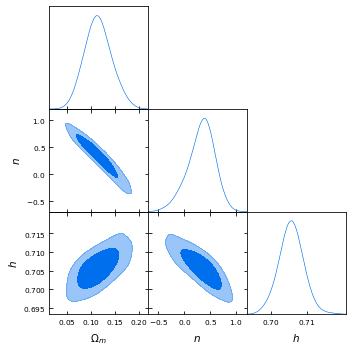

In [14]:
# from mpi4py import MPI

# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()

# from cobaya.run import run
# from cobaya.log import LoggedError

# success = False
# try:
#     updated_info_PS, products = run(info_PS)
#     success = True
# except LoggedError as err:
#     pass

# # Did it work? (e.g. did not get stuck)
# success = all(comm.allgather(success))

# if not success and rank == 0:
#     print("Sampling failed!")
# all_chains = comm.gather(products.products()["sample"], root=0)

# # Pass all of them to GetDist in rank = 0

# if rank == 0:
#     from getdist.mcsamples import MCSamplesFromCobaya
#     gdsamples_PS = MCSamplesFromCobaya(updated_info_PS, all_chains)

# # Manually concatenate them in rank = 0 for some custom manipulation,
# # skipping 1st 3rd of each chain

# copy_and_skip_1st_3rd = lambda chain: chain[int(len(chain) / 3):]
# if rank == 0:
#     full_chain = copy_and_skip_1st_3rd(all_chains[0])
#     for chain in all_chains[1:]:
#         full_chain.append(copy_and_skip_1st_3rd(chain))
#     # The combined chain is now `full_chain`
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
gdsamples_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_PS, ["omega_m", "n", "h0"], filled=True)

mean = gdsamples_PS.getMeans()[:3]
sigma = np.sqrt(np.array(gdsamples_PS.getVars()[:3]))
covmat = gdsamples_PS.getCovMat().matrix[:3, :3]
# plt.savefig("figures/Pantheoncobaya.pdf", format="pdf", bbox_inches="tight")
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat)  

%time

[root] *WARNING* outlier fraction 0.05782312925170068 
Mean:
[0.10395384 0.4346741  0.70453411]
1 sigma:
[0.02708259 0.23152599 0.00330458]
Covariance matrix:
[[ 7.33466929e-04 -5.87698443e-03  5.18950716e-05]
 [-5.87698443e-03  5.36042855e-02 -6.05385348e-04]
 [ 5.18950716e-05 -6.05385348e-04  1.09202643e-05]]


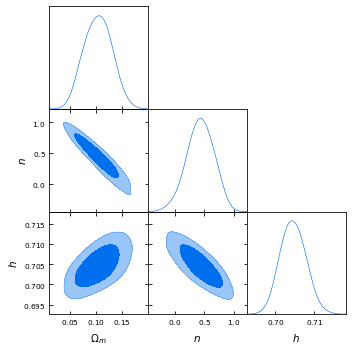

In [6]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_PS, ["omega_m", "n", "h0"], filled=True)

mean = gdsamples_PS.getMeans()[:3]
sigma = np.sqrt(np.array(gdsamples_PS.getVars()[:3]))
covmat = gdsamples_PS.getCovMat().matrix[:3, :3]
# plt.savefig("figures/Pantheoncobaya.pdf", format="pdf", bbox_inches="tight")
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat)  

# SCP Union 2.1

In [6]:
# !wget http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
d = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
z1 = d.T[1]
mu1 = d.T[2]
errmu= d.T[3]
dlabel = 'SCP_2.1'
label = {"Z_SN":z1,"DMdata_SN":mu1,"Error_DM_SN":errmu}
data_SN=pd.DataFrame(label)
#print(data_SN)
sort_data_SN=data_SN.sort_values(by=['Z_SN'],ignore_index=True)
# !wget https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
cov_mat = np.genfromtxt('SCPUnion2.1_covmat_sys.txt')
z=sort_data_SN.Z_SN
mu=sort_data_SN.DMdata_SN

In [7]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnlsn(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
        return loglikely


In [8]:
info_SN = {
    "likelihood": {
        "external": lnlsn},
    "params": dict([
        ("omega_m", {
            "prior": 
            { "dist": "norm", "loc": 0.09, "scale": 5*0.025}, "ref": 0.1,
            "latex": r"\Omega_m","proposal":0.001}),
        ("n", {
            "prior": {"dist": "norm", "loc": 1.33, "scale": 5*0.205}, "ref": 1.2,
            "latex": r"n","proposal":0.001}),
       ("h0", {
            "prior": {"dist": "norm", "loc": 0.696, "scale": 5*0.004}, "ref": 0.7,
            "latex": r"h","proposal":0.001}) ]),
       "sampler": {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.1, "Rminus1_cl_stop": 0.2, "learn_proposal": True}}}
updated_info_SN, sampler_SN = run(info_SN)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 26.3}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:0.1, n:1.2, h0:0.7
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-06-19 09:49:10 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.807
[mcmc]  - Convergence of means: R-1 = 15.687246 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.706
[mcmc]  - Convergen

[root] *WARNING* outlier fraction 0.007142857142857143 
Mean:
[0.0926524  0.59986028 0.6929954 ]
1 sigma:
[0.0489834  0.41621582 0.00873595]
Covariance matrix:
[[ 2.39937299e-03 -1.75526993e-02  6.78009014e-05]
 [-1.75526993e-02  1.73235610e-01 -1.73462205e-03]
 [ 6.78009014e-05 -1.73462205e-03  7.63168577e-05]]


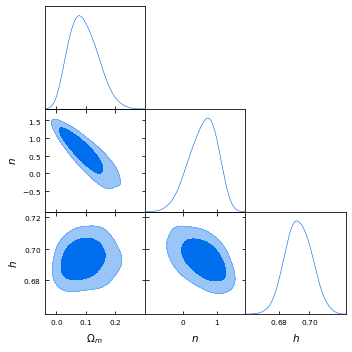

In [14]:
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_SN, ["omega_m", "n", "h0"], filled=True)
mean = gdsamples_SN.getMeans()[:3]
sigma = np.sqrt(np.array(gdsamples_SN.getVars()[:3]))
covmat = gdsamples_SN.getCovMat().matrix[:3, :3]
plt.savefig("figures/SCPcobaya.pdf", format="pdf", bbox_inches="tight")
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat) 

# GWTC-3

In [19]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/mnt/49258d32-6ae7-47af-b8e9-cd883888e8b3/github/HubbleConstant-ConstraintsForVCG/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z1 = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl1 = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup1 = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow1 = pd.concat(dllowcollect)
label2 = {"EventName":finalevents,"ZGW":z1,"dLdataGW":finaldl1,"DLUplimit":finaldlup1,"DLLowlimit":finaldllow1}
Final_GW=pd.DataFrame(label2)
sort_data_GW=Final_GW.sort_values(by=['ZGW'],ignore_index=True)

z=sort_data_GW.ZGW
finaldl=sort_data_GW.dLdataGW
finaldlup=sort_data_GW.DLUplimit
finaldllow=sort_data_GW.DLLowlimit
a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu[h]+=5*log(i,10)+25
  h+=1
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu,dmtop):
  dmtoperr[r]+=j-i
  r+=1
for (i,j) in zip(mu,dmbottom):
  dmbottomerr[s]+=i-j
  s+=1

In [20]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=np.zeros(len(z))
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02


#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m

# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnlgw(omega_m, n,h0):
        if(omega_m<=0.0 or omega_m>=1 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)): # if data point lower than theoretical: take bottom error
                # if data point above th : take upper error
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
                if dmu[i]>0:
                    sigma[i]=dmbottomerr[i]
                else:
                    sigma[i]=dmtoperr[i]
            loglikely= -0.5*np.sum(dmu**2/sigma**2)
#             for i in range(len(z)):   #(Average of asymetrical errors)
#                 dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
#                 sigma[i]= (dmbottomerr[i] + dmtoperr[i])/2
#             loglikely= -0.5*np.sum(dmu**2/sigma**2)
        return loglikely

In [21]:
info_GW = {
    "likelihood": {
        "external": lnlgw},
    "params": dict([
        ("omega_m", {
            "prior": 
            { "dist": "norm", "loc": 0.09, "scale": 5*0.025}, "ref": 0.1,
            "latex": r"\Omega_m","proposal":0.001}),
        ("n", {
            "prior": {"dist": "norm", "loc": 1.33, "scale": 5*0.205}, "ref": 1.2,
            "latex": r"n","proposal":0.001}),
       ("h0", {
            "prior": {"dist": "norm", "loc": 0.696, "scale": 5*0.004}, "ref": 0.7,
            "latex": r"h","proposal":0.001}) ]),
"sampler": {
    "mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.1, "Rminus1_cl_stop": 0.2, "learn_proposal": True}}}

updated_info_GW, sampler_GW = run(info_GW)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 103.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:0.1, n:1.2, h0:0.7
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-06-19 15:29:27 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 13.688476 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.955
[mcmc]  - Converge

[root] *WARNING* outlier fraction 0.09798534798534798 
Mean:
[0.1302401  0.81471207 0.69359337]
1 sigma:
[0.0912211  0.72502986 0.01753216]
Covariance matrix:
[[ 8.32128882e-03 -8.21003899e-03 -1.41606964e-04]
 [-8.21003899e-03  5.25668297e-01 -3.21802145e-03]
 [-1.41606964e-04 -3.21802145e-03  3.07376460e-04]]


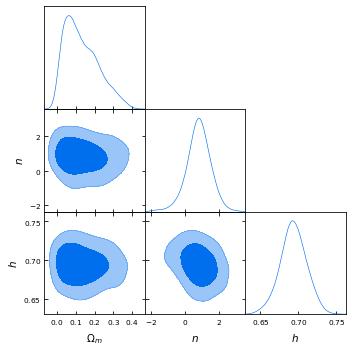

In [22]:
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"],ignore_rows=0.3)
gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples_GW, ["omega_m", "n", "h0"], filled=True)
mean = gdsamples_GW.getMeans()[:3]
sigma = np.sqrt(np.array(gdsamples_GW.getVars()[:3]))
covmat = gdsamples_GW.getCovMat().matrix[:3, :3]
# plt.savefig("figures/GWTCcobaya.pdf", format="pdf", bbox_inches="tight")
print("Mean:")
print(mean)
print("1 sigma:")
print(sigma)
print("Covariance matrix:")
print(covmat) 

# GW and PN Cobaya

[root] *WARNING* outlier fraction 0.02738095238095238 
GW Mean: 
[0.12346399 0.75236569 0.68956787]
GW Covariance matrix:
[[ 7.54444596e-03 -1.03710396e-02 -1.76298925e-04]
 [-1.03710396e-02  6.26785627e-01 -4.89651561e-03]
 [-1.76298925e-04 -4.89651561e-03  3.54000395e-04]]


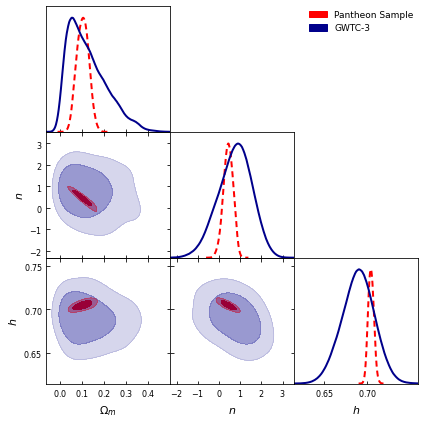

In [18]:
# Export the results to GetDist


# gd_sample_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"])
# # Analyze and plot
# mean_PS = gd_sample_PS.getMeans()[:3]
# covmat_PS = gd_sample_PS.getCovMat().matrix[:3, :3]
# print("PS Mean:")
# print(mean_PS)
# print("PS Covariance matrix:")
# print(covmat_PS)


# gd_sample_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"])
# # Analyze and plot
# mean_SN = gd_sample_SN.getMeans()[:3]
# covmat_SN = gd_sample_SN.getCovMat().matrix[:3, :3]
# print(" SCP Mean:")
# print(mean_SN)
# print("SCP Covariance matrix:")
# print(covmat_SN)


# 
gdsamples_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"],ignore_rows=0.3)
# Analyze and plot
mean_GW = gdsamples_GW.getMeans()[:3]
covmat_GW = gdsamples_GW.getCovMat().matrix[:3, :3]
print("GW Mean: ")
print(mean_GW)
print("GW Covariance matrix:")
print(covmat_GW)



g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([gdsamples_PS, gdsamples_GW], ["omega_m", "n", "h0"], 
    filled=True, 
    legend_labels=['Pantheon Sample', 'GWTC-3'], 
    legend_loc='upper right', 
    line_args=[{'lw':2,'ls':'--', 'color':'red'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['red','darkblue'],
#     title_limit=1, # first title limit (for 1D plots) is 68% by default
#     markers={'h0':0}
               )
plt.savefig("figures/GWPantheonCobaya.pdf", format="pdf", bbox_inches="tight")

# PN and SCP Cobaya

[root] *WARNING* outlier fraction 0.019444444444444445 
PS Mean:
[0.09389865 0.52383324 0.70319113]
PS Covariance matrix:
[[ 1.11719950e-03 -9.55077611e-03  1.17876760e-04]
 [-9.55077611e-03  8.73718082e-02 -1.17816617e-03]
 [ 1.17876760e-04 -1.17816617e-03  1.94236364e-05]]
[root] *WARNING* outlier fraction 0.041666666666666664 
 SCP Mean:
[0.09281775 0.58847061 0.69317363]
SCP Covariance matrix:
[[ 2.50110852e-03 -1.95706095e-02  1.08091202e-04]
 [-1.95706095e-02  2.06412273e-01 -2.32518322e-03]
 [ 1.08091202e-04 -2.32518322e-03  8.88939973e-05]]


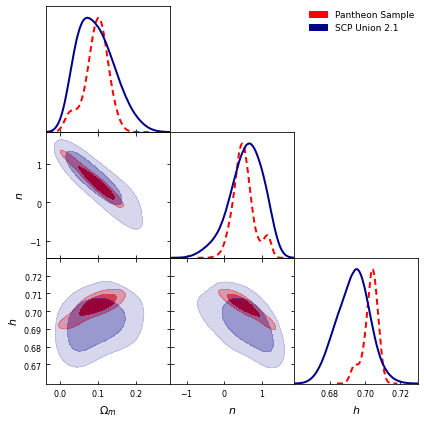

In [9]:
# Export the results to GetDist


gd_sample_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"])
# Analyze and plot
mean_PS = gd_sample_PS.getMeans()[:3]
covmat_PS = gd_sample_PS.getCovMat().matrix[:3, :3]
print("PS Mean:")
print(mean_PS)
print("PS Covariance matrix:")
print(covmat_PS)


gd_sample_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"])
# Analyze and plot
mean_SN = gd_sample_SN.getMeans()[:3]
covmat_SN = gd_sample_SN.getCovMat().matrix[:3, :3]
print(" SCP Mean:")
print(mean_SN)
print("SCP Covariance matrix:")
print(covmat_SN)


# gdplot_GW = gdplt.get_subplot_plotter()
# gdplot_GW.triangle_plot(gd_sample_GW, ["omega_m", "n", "h0"], filled=True)
# gd_sample_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"])
# # Analyze and plot
# mean_GW = gd_sample_GW.getMeans()[:3]
# covmat_GW = gd_sample_GW.getCovMat().matrix[:3, :3]
# print("GW Mean: ")
# print(mean_GW)
# print("GW Covariance matrix:")
# print(covmat_GW)
g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([gd_sample_PS, gd_sample_SN], ["omega_m", "n", "h0"], 
    filled=True, 
    legend_labels=['Pantheon Sample', 'SCP Union 2.1'], 
    legend_loc='upper right', 
    line_args=[{'lw':2,'ls':'--', 'color':'red'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['red','darkblue'],
#     title_limit=1, # first title limit (for 1D plots) is 68% by default
#     markers={'h0':0}
               )
plt.savefig("figures/SCPPantheonCobaya.pdf", format="pdf", bbox_inches="tight")




# GW and SCP Cobaya

In [8]:
# Export the results to GetDist


# gd_sample_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"])
# # Analyze and plot
# mean_PS = gd_sample_PS.getMeans()[:3]
# covmat_PS = gd_sample_PS.getCovMat().matrix[:3, :3]
# print("PS Mean:")
# print(mean_PS)
# print("PS Covariance matrix:")
# print(covmat_PS)


gd_sample_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"])
# Analyze and plot
mean_SN = gd_sample_SN.getMeans()[:3]
covmat_SN = gd_sample_SN.getCovMat().matrix[:3, :3]
print(" SCP Mean:")
print(mean_SN)
print("SCP Covariance matrix:")
print(covmat_SN)


gd_sample_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"])
# Analyze and plot
mean_GW = gd_sample_GW.getMeans()[:3]
covmat_GW = gd_sample_GW.getCovMat().matrix[:3, :3]
print("GW Mean: ")
print(mean_GW)
print("GW Covariance matrix:")
print(covmat_GW)





[root] *WARNING* outlier fraction 0.059027777777777776 
 SCP Mean:
[0.08049946 0.69251186 0.69184335]
SCP Covariance matrix:
[[ 2.98394601e-03 -2.37095830e-02  1.15902798e-04]
 [-2.37095830e-02  2.38084126e-01 -2.35651812e-03]
 [ 1.15902798e-04 -2.35651812e-03  9.41285755e-05]]
[root] *WARNING* outlier fraction 0.033928571428571426 
GW Mean: 
[0.135344   0.77702507 0.68914128]
GW Covariance matrix:
[[ 7.06302677e-03 -1.58472956e-02 -9.44896220e-05]
 [-1.58472956e-02  5.81484451e-01 -4.72740451e-03]
 [-9.44896220e-05 -4.72740451e-03  3.52861424e-04]]


NameError: name 'gd_sample_PS' is not defined

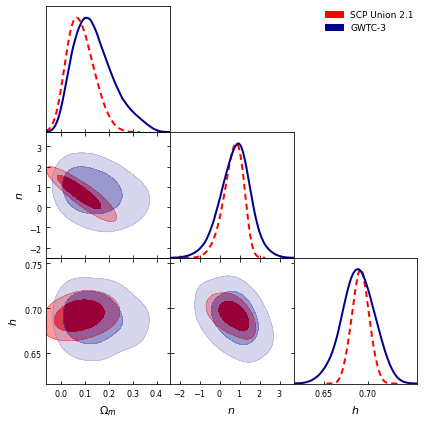

In [9]:
g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([gd_sample_SN, gd_sample_GW], ["omega_m", "n", "h0"], 
    filled=True, 
    legend_labels=['SCP Union 2.1', 'GWTC-3'], 
    legend_loc='upper right', 
    line_args=[{'lw':2,'ls':'--', 'color':'red'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['red','darkblue'],
#     title_limit=1, # first title limit (for 1D plots) is 68% by default
#     markers={'h0':0}
               )
plt.savefig("figures/SCPGWCobaya.pdf", format="pdf", bbox_inches="tight")

# GW PS SCP Cobaya

In [11]:
# Export the results to GetDist


gdsamples_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"])


gdsamples_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"])





[root] *WARNING* outlier fraction 0.024404761904761905 
[root] *WARNING* outlier fraction 0.021111111111111112 


NameError: name 'updated_info_GW' is not defined

In [15]:
gd_sample_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"])


[root] *WARNING* outlier fraction 0.033928571428571426 


NameError: name 'gdsamples_GW' is not defined

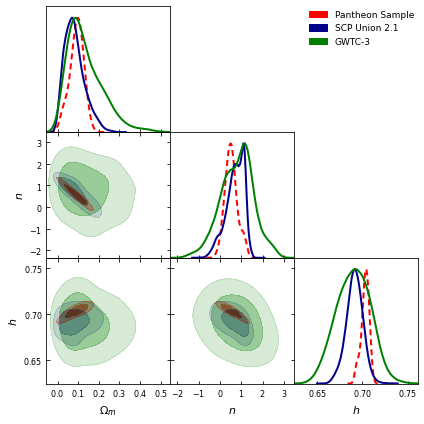

In [17]:

g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([gdsamples_PS, gdsamples_SN, gd_sample_GW], ["omega_m", "n", "h0"], 
    filled=True, 
    legend_labels=['Pantheon Sample', 'SCP Union 2.1', 'GWTC-3'], 
    legend_loc='upper right', 
    line_args=[{'lw':2,'ls':'--', 'color':'red'},
               {'lw':2, 'color':'darkblue'},
               {'lw':2, 'color':'green'}], 
    contour_colors=['red','darkblue','green'],
#     title_limit=1, # first title limit (for 1D plots) is 68% by default
#     markers={'h0':0}
               )
plt.savefig("figures/PantheonSCPGWCobaya.pdf", format="pdf", bbox_inches="tight")